<a href="https://colab.research.google.com/github/gavin-bauer/earth-vital-signs/blob/master/notebooks/carbon%20dioxide%20levels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GLOBAL CARBON DIOXIDE LEVELS ANALYSIS**

## **About the project**
Below is code part of a personal project called [Earth's Vital Signs](https://github.com/gavin-bauer/earth-vital-signs/blob/master/README.md) intended to develop my proficiency in Data Science Analytics tools and work on one of the most defining issues of our time. 

## **Findings**
Atmospheric CO2 levels have increased over the past 60 years, **exceeding the 410 parts per million (ppm) milestone in 2018**, the highest level since the Pliocene Era (as per National Geographic). 

Moreover, atmospheric CO2 levels appear to be cyclical, with annual maximums and minimums. An annual cycle can be deciphered where **CO2 peaks in May and has a low in November.**

<p align="center">
  <img src="https://github.com/gavin-bauer/earth-vital-signs/blob/master/assets/img/co2ppm_evo.png?raw=1" width="400">
  <img src="https://github.com/gavin-bauer/earth-vital-signs/blob/master/assets/img/co2ppm_hotr.png?raw=1" width=400">
</p>

> ### 😲 Did you know ?
>
>**CO2 peaks in May every year**. By June the levels begin falling, as spring kicks into high gear in the Northern Hemisphere, where most of the planet's land is concentrated, and plants draw CO2 out of the atmosphere to fuel their new growth. 
>
>**By November, the CO2 level is typically 5 or 6 ppm lower than its spring levels.**
**Then the curve turns upward again in the winter**, plants stop making new carbohydrates but continue to burn the old, respiring CO2 back into the atmosphere.

## **Datasets**
* [Kaggle](https://www.kaggle.com/ucsandiego/carbon-dioxide)
* [NASA](https://disc.gsfc.nasa.gov/datasets/AIRS3C2D_V005/summary)

### **Code**

In [0]:
!pip install kaggle
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6
!pip install netCDF4
!pip install cmocean

In [0]:
import os
from os.path import join
from calendar import month_abbr
from google.colab import drive
from importlib.machinery import SourceFileLoader
import numpy as np
import pandas as pd
from netCDF4 import Dataset  
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import cmocean
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'

In [0]:
def download_co2ppm_dataset(ROOT):
  ROOT = ROOT
  drive.mount(ROOT)
  my_modules = SourceFileLoader('my_modules', join(ROOT, 'My Drive/my_modules/kaggle2colab.py')).load_module()
  my_modules.interact()
  !kaggle datasets download -d ucsandiego/carbon-dioxide
  !unzip carbon-dioxide.zip
  dataset = pd.read_csv('archive.csv')
  return dataset

def process_co2ppm_dataset(dataset):
  dataset = dataset
  cols_to_keep = ['Year', 'Month', 'Carbon Dioxide (ppm)']
  dataset = dataset[cols_to_keep]
  dataset = dataset.dropna()
  month = dataset['Month'].apply(str)
  year = dataset['Year'].apply(str)
  month_year = month.str.cat(year, sep='/')
  month_year = pd.to_datetime(month_year)
  dataset['Date'] = month_year
  dataset = dataset.drop(['Year', 'Month'], axis=1)
  return dataset

def plot_co2ppm(dataset):
  dataset = process_co2ppm_dataset(dataset)
  date = dataset['Date']
  co2_ppm = dataset['Carbon Dioxide (ppm)']
  fig, ax = plt.subplots()
  ax.plot(date, co2_ppm)
  ax.set(xlabel='year', ylabel='CO2 ppm', title='CO2 ppm Evolution By Year')
  return ax

def get_mauna_lao_data(link, column_names):
  data = pd.read_csv(link, sep='\s+', comment='#', na_values=-999.99,
                         names=column_names)
  data['timestamp'] = data.apply(lambda x: pd.Timestamp(year=int(x.year),
                                                                month=int(x.month),
                                                                day=int(x.day)),
                                         axis=1)
  data = data[['timestamp', 'ppm']].set_index('timestamp').ffill()
  return data

def plot_mauna_lao(dataset):
  data_subset = dataset['1975':'2018']
  n_years = data_subset.index.year.max() - data_subset.index.year.min()
  z = np.ones((n_years +1 , 12)) * np.min(data_subset.ppm)
  for d, y in data_subset.groupby([data_subset.index.year, data_subset.index.month]):
    z[data_subset.index.year.max() - d[0], d[1] - 1] = y.mean()[0]
  
  fig, ax = plt.subplots()
  plt.pcolor(np.flipud(z), cmap='hot_r')
  plt.yticks(np.arange(0, n_years+1, 2)+.5,
            range(data_subset.index.year.min(), data_subset.index.year.max()+1, 2));
  plt.xticks(np.arange(13)-.5, month_abbr)
  plt.xlim((0, 12))
  plt.colorbar().set_label('atmospheric CO2 in ppm')
  ax.set(xlabel='month', ylabel='year', title='CO2 ppm Evolution By Month And Year')

  return ax

In [0]:
ROOT = '/content/gdrive'
dataset = download_co2ppm_dataset(ROOT)

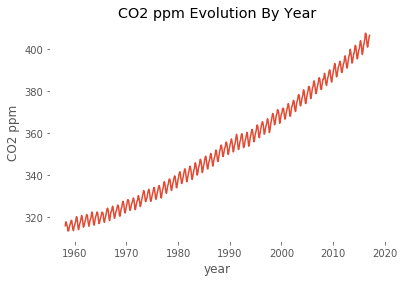

In [0]:
PATH = os.path.join('/content', 'co2ppm_evo')
ax = plot_co2ppm(dataset)
chart = ax.get_figure()
chart.savefig(PATH, dpi=150)

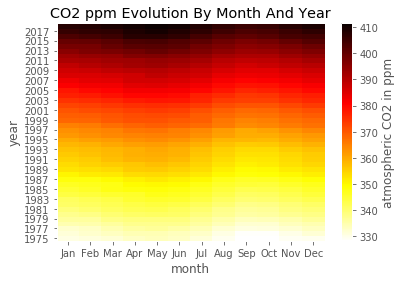

In [0]:
# plot mauna lao CO2 weekly trends 
link = 'ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt'
column_names = ['year', 'month', 'day', 'decimal', 'ppm',
                'days', '1_yr_ago',  '10_yr_ago', 'since_1800']

dataset = get_mauna_lao_data(link, column_names)

PATH = os.path.join('/content', 'co2ppm_hotr')
ax = plot_mauna_lao(dataset)
chart = ax.get_figure()
chart.savefig(PATH, dpi=150)